In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import optuna
from tqdm import tqdm

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):
    def __init__(self, latent_dim=256, leaky_slope=0.01, dropout_rate=0.1):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.leaky_slope = leaky_slope
        
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(self.leaky_slope),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_rate),
            
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(self.leaky_slope),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_rate),
            
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(self.leaky_slope),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_rate),
            
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(self.leaky_slope),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_rate),
            
            nn.Flatten(),
            nn.Linear(1536, 768),
            nn.LeakyReLU(self.leaky_slope),
            nn.Dropout(dropout_rate),
            nn.Linear(768, self.latent_dim * 2)  # *2 for mu and logvar
        )

    def forward(self, x):
        return self.layers(x)

class Discriminator(nn.Module):
    def __init__(self, latent_dim=256, leaky_slope=0.01, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(leaky_slope),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 32),
            nn.LeakyReLU(leaky_slope),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

class ModifiedDecoder(nn.Module):
    def __init__(self, latent_dim=256, leaky_slope=0.01, dropout_rate=0.1):
        super(ModifiedDecoder, self).__init__()
        self.dense_layers = nn.Sequential(
            nn.Linear(latent_dim, 768),
            nn.LeakyReLU(leaky_slope),
            nn.Dropout(dropout_rate),
            nn.Linear(768, 2048),
            nn.LeakyReLU(leaky_slope),
            nn.Dropout(dropout_rate)
        )
        
        self.conv_layers = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(leaky_slope),
            nn.Dropout2d(dropout_rate),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(leaky_slope),
            nn.Dropout2d(dropout_rate)
        )
        
        self.final_layer = nn.Linear(16 * 64 * 64, 3 * 64 * 64)

    def forward(self, x):
        x = self.dense_layers(x)
        x = x.view(-1, 8, 16, 16)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.final_layer(x)
        x = x.view(-1, 3, 64, 64)
        return x

class FullModel(nn.Module):
    def __init__(self, latent_dim=256, leaky_slope=0.01, dropout_rate=0.1):
        super(FullModel, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim, leaky_slope, dropout_rate)
        self.decoder = ModifiedDecoder(latent_dim, leaky_slope, dropout_rate)
        self.discriminator = Discriminator(latent_dim, leaky_slope, dropout_rate)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu, logvar = encoded.chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        real_distribution = torch.randn_like(z)
        d_real = self.discriminator(real_distribution)
        d_fake = self.discriminator(z)
        return decoded, mu, logvar, d_real, d_fake

class CustomDataset(Dataset):
    def __init__(self, input_dir, output_dir):
        self.input_files = sorted([f for f in os.listdir(input_dir) if f.startswith('norm_gen_')])
        self.output_files = sorted([f for f in os.listdir(output_dir) if f.startswith('norm_d_sample_')])
        self.input_dir = input_dir
        self.output_dir = output_dir

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_data = np.load(os.path.join(self.input_dir, self.input_files[idx]))
        output_data = np.load(os.path.join(self.output_dir, self.output_files[idx]))
        return torch.FloatTensor(input_data), torch.FloatTensor(output_data)

def objective(trial):
    # Hyperparameters to optimize
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    leaky_slope = trial.suggest_float('leaky_slope', 0.01, 0.3)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    # Fixed latent dimension
    latent_dim = 256

    # Create model and optimizer
    model = FullModel(latent_dim=latent_dim, leaky_slope=leaky_slope, dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    model.train()
    for epoch in range(5):  # We'll use 5 epochs for quick evaluation
        epoch_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            
            decoded, mu, logvar, d_real, d_fake = model(x)
            
            reconstruction_loss = F.mse_loss(decoded, y)
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            discriminator_loss = F.binary_cross_entropy(d_real, torch.ones_like(d_real)) + \
                                 F.binary_cross_entropy(d_fake, torch.zeros_like(d_fake))
            
            total_loss = reconstruction_loss + kl_divergence + discriminator_loss
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += total_loss.item()
        
        epoch_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            decoded, mu, logvar, d_real, d_fake = model(x)
            reconstruction_loss = F.mse_loss(decoded, y)
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            discriminator_loss = F.binary_cross_entropy(d_real, torch.ones_like(d_real)) + \
                                 F.binary_cross_entropy(d_fake, torch.zeros_like(d_fake))
            val_loss += (reconstruction_loss + kl_divergence + discriminator_loss).item()
    
    val_loss /= len(val_loader)
    return val_loss

# ... (Keep your dataset loading and splitting code as is)
input_dir = r"H:\DDGAN\norm_generator_full"
output_dir = r"H:\DDGAN\norm_d"
dataset = CustomDataset(input_dir, output_dir)

# Split the dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)  # Adjust the number of trials as needed

print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train the final model with the best hyperparameters
best_lr = trial.params['lr']
best_leaky_slope = trial.params['leaky_slope']
best_dropout_rate = trial.params['dropout_rate']

final_model = FullModel(latent_dim=256, leaky_slope=best_leaky_slope, dropout_rate=best_dropout_rate).to(device)
final_optimizer = optim.Adam(final_model.parameters(), lr=best_lr)

num_epochs = 200  # Adjust as needed
for epoch in tqdm(range(num_epochs)):
    final_model.train()
    epoch_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        final_optimizer.zero_grad()
        
        decoded, mu, logvar, d_real, d_fake = final_model(x)
        
        reconstruction_loss = F.mse_loss(decoded, y)
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        discriminator_loss = F.binary_cross_entropy(d_real, torch.ones_like(d_real)) + \
                             F.binary_cross_entropy(d_fake, torch.zeros_like(d_fake))
        
        total_loss = reconstruction_loss + kl_divergence + discriminator_loss
        total_loss.backward()
        final_optimizer.step()
        
        epoch_loss += total_loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# Save the final model
torch.save(final_model.state_dict(), 'final_model_optimized.pth')
print("Optimization and training completed!")

In [2]:
"""
Best trial:
Value: 1.3921865224838257
Params: 
    lr: 0.000959133154651437
    leaky_slope: 0.010213377348000388
    dropout_rate: 0.10827723274036115
"""

def test_cuda():
    if torch.cuda.is_available():
        try:
            x = torch.randn(1000, 1000).cuda()
            y = torch.matmul(x, x.t())
            print("CUDA is working correctly")
        except RuntimeError as e:
            print(f"CUDA error in simple test: {e}")
    else:
        print("CUDA is not available")

test_cuda()

CUDA is working correctly


h:\python 3.12.3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


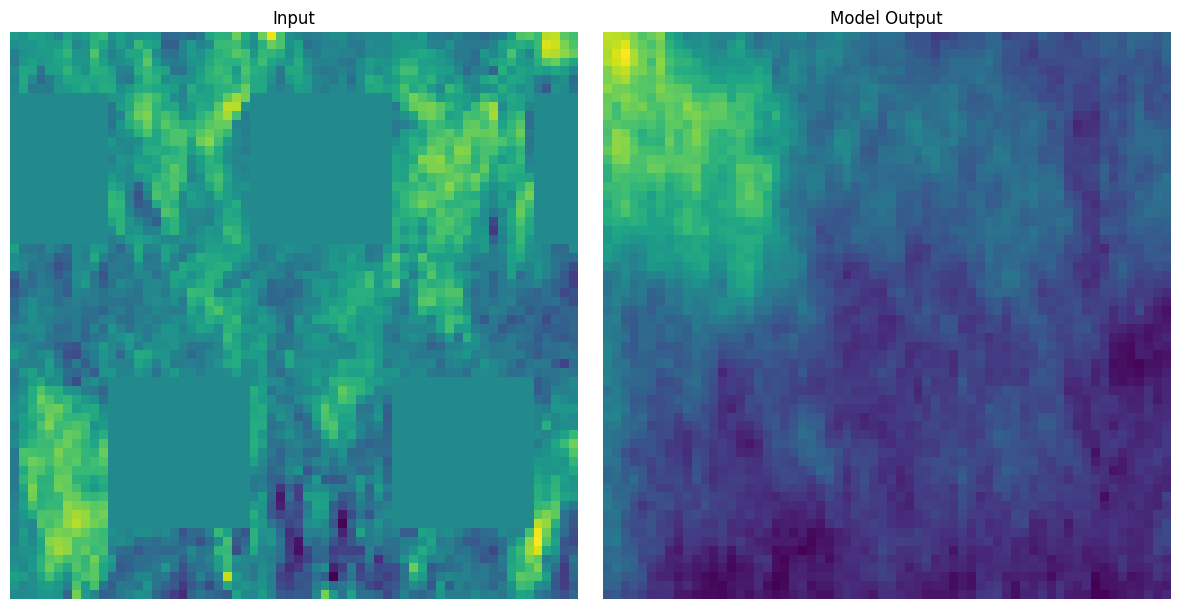

Input shape: (3, 384, 64)
Output shape: (3, 64, 64)
Input min/max: -1.0000/0.7354
Output min/max: -0.0860/0.2232
Latent space mean (mu) shape: torch.Size([1, 256])
Latent space log variance (logvar) shape: torch.Size([1, 256])
Discriminator output for real distribution: 0.5014
Discriminator output for generated distribution: 0.5048


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import optuna
from tqdm import tqdm

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):
    def __init__(self, latent_dim=256, leaky_slope=0.01, dropout_rate=0.1):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.leaky_slope = leaky_slope
        
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(self.leaky_slope),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_rate),
            
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(self.leaky_slope),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_rate),
            
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(self.leaky_slope),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_rate),
            
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(self.leaky_slope),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_rate),
            
            nn.Flatten(),
            nn.Linear(1536, 768),
            nn.LeakyReLU(self.leaky_slope),
            nn.Dropout(dropout_rate),
            nn.Linear(768, self.latent_dim * 2)  # *2 for mu and logvar
        )

    def forward(self, x):
        return self.layers(x)

class Discriminator(nn.Module):
    def __init__(self, latent_dim=256, leaky_slope=0.01, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(leaky_slope),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 32),
            nn.LeakyReLU(leaky_slope),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

class ModifiedDecoder(nn.Module):
    def __init__(self, latent_dim=256, leaky_slope=0.01, dropout_rate=0.1):
        super(ModifiedDecoder, self).__init__()
        self.dense_layers = nn.Sequential(
            nn.Linear(latent_dim, 768),
            nn.LeakyReLU(leaky_slope),
            nn.Dropout(dropout_rate),
            nn.Linear(768, 2048),
            nn.LeakyReLU(leaky_slope),
            nn.Dropout(dropout_rate)
        )
        
        self.conv_layers = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(leaky_slope),
            nn.Dropout2d(dropout_rate),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(leaky_slope),
            nn.Dropout2d(dropout_rate)
        )
        
        self.final_layer = nn.Linear(16 * 64 * 64, 3 * 64 * 64)

    def forward(self, x):
        x = self.dense_layers(x)
        x = x.view(-1, 8, 16, 16)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.final_layer(x)
        x = x.view(-1, 3, 64, 64)
        return x

class FullModel(nn.Module):
    def __init__(self, latent_dim=256, leaky_slope=0.01, dropout_rate=0.1):
        super(FullModel, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim, leaky_slope, dropout_rate)
        self.decoder = ModifiedDecoder(latent_dim, leaky_slope, dropout_rate)
        self.discriminator = Discriminator(latent_dim, leaky_slope, dropout_rate)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu, logvar = encoded.chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        real_distribution = torch.randn_like(z)
        d_real = self.discriminator(real_distribution)
        d_fake = self.discriminator(z)
        return decoded, mu, logvar, d_real, d_fake

# Assuming you have your FullModel class defined here
# from your_model_file import FullModel

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_path = r"H:\DDGAN\norm_generator_full\norm_gen_0.npy"
true_path = r"H:\DDGAN\norm_d\norm_d_sample_0.npy"
model_path = r"H:\DDGAN\final_model_optimized.pth"
model = FullModel(latent_dim=256, leaky_slope=0.010213377348000388)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()
input_data = np.load(input_path)
input_tensor = torch.FloatTensor(input_data).unsqueeze(0).to(device)
true_data = np.load(true_path)


with torch.no_grad():
    decoded, mu, logvar, d_real, d_fake = model(input_tensor)

# Convert the output back to numpy for visualization
output_data = decoded.squeeze(0).cpu().numpy()

# Visualize input and output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Input visualization
ax1.imshow(np.transpose(true_data[0]))
ax1.set_title('Input')
ax1.axis('off')


ax2.imshow(np.transpose(output_data[0]))
ax2.set_title('Model Output')
ax2.axis('off')

plt.tight_layout()
# output_dir = r"H:\DDGAN\results"
# os.makedirs(output_dir, exist_ok=True)
# plt.savefig(os.path.join(output_dir, 'input_output_comparison.png'))
plt.show()

# np.save(os.path.join(output_dir, 'model_output_0.npy'), output_data)

print(f"Input shape: {input_data.shape}")
print(f"Output shape: {output_data.shape}")
print(f"Input min/max: {input_data.min():.4f}/{input_data.max():.4f}")
print(f"Output min/max: {output_data.min():.4f}/{output_data.max():.4f}")
print(f"Latent space mean (mu) shape: {mu.shape}")
print(f"Latent space log variance (logvar) shape: {logvar.shape}")
print(f"Discriminator output for real distribution: {d_real.item():.4f}")
print(f"Discriminator output for generated distribution: {d_fake.item():.4f}")